In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch

env = gym.make('CartPole-v1')

print("Action Space: ", env.action_space)
print("Obs Space: ", env.observation_space)


SEED = 0
torch.manual_seed(SEED)


Action Space:  Discrete(2)
Obs Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [9]:
W = torch.normal(0,1,size=(5,4)) 
x = torch.zeros(size=(1,5)) # 4 obs, 1 action

params = [W]

for p in params:
    p.requires_grad = True

print(W)
print(x)

tensor([[ 0.4397,  0.1124,  0.6408,  0.4412],
        [ 0.2055, -0.4503, -0.5731, -0.5554],
        [ 0.5943,  1.5419,  0.5073, -0.5910],
        [-1.3253,  0.1886, -0.0691, -0.4949],
        [-1.4959, -0.1938,  0.4455,  1.3253]], requires_grad=True)
tensor([[0., 0., 0., 0., 0.]])


In [34]:
observation, info = env.reset(seed=SEED)
obs = torch.tensor(observation)

losses = []  # List to store loss values


In [35]:
actual_obs = [[] for _ in range(4)]
pred_obs = [[] for _ in range(4)]

for _ in range(50):

    action = env.action_space.sample()
    x[0,:4] = obs
    x[0,4] = torch.tensor([action], dtype=torch.float)

    # forward pass - make prediction
    y =  x @ W

    observation, reward, terminated, truncated, info = env.step(action)

    obs = torch.tensor(observation)

    loss = torch.abs(obs - y).mean()

    for i in range(4):
        actual_obs[i].append(obs[i].item())
        pred_obs[i].append(y[0, i].item())
        
    #backward pass
    W.grad = None
    loss.backward()
    W.data += -0.1 * W.grad

    losses.append(loss.item())
    # print(f"Loss: {loss.item()}", end="\r")

    # print(observation, reward, terminated, truncated, info)
    if terminated or truncated:
        observation, info = env.reset(seed=SEED)
        obs = torch.tensor(observation)
        break


env.close()


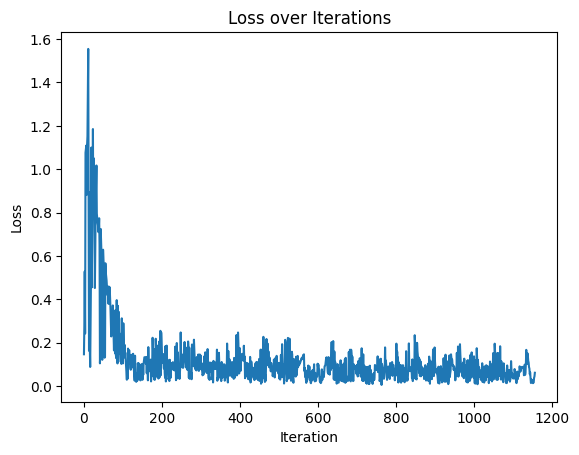

In [32]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

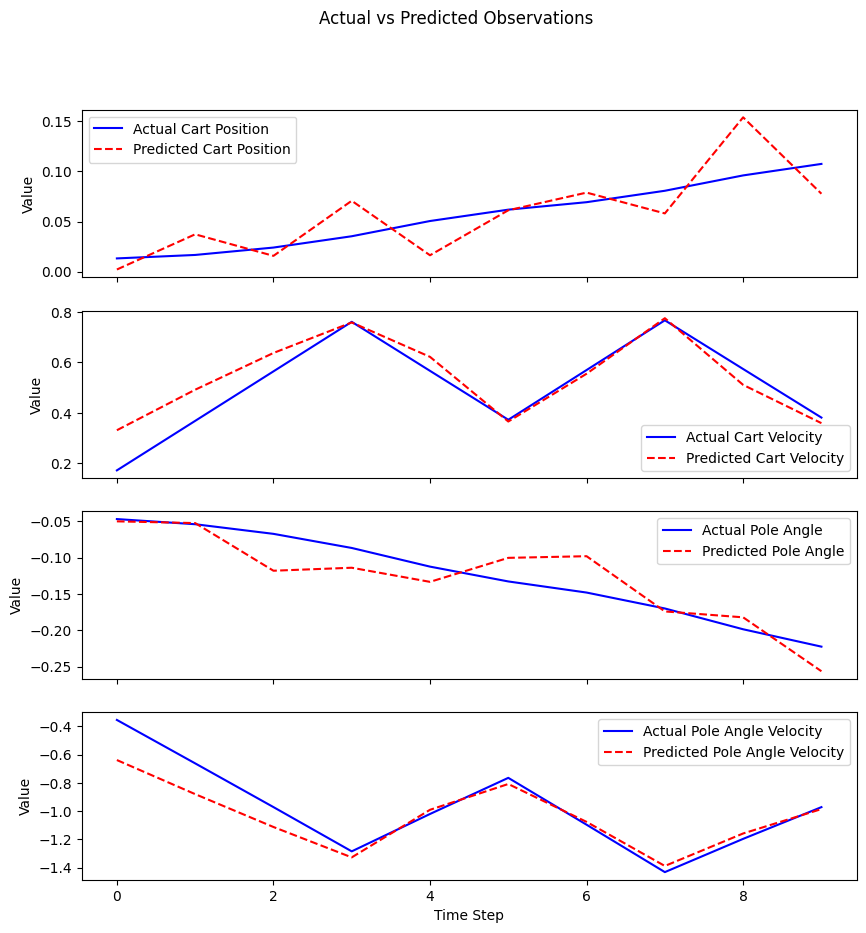

In [36]:
# Create subplots for each set of predicted and actual values
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

legend_labels = {
    1: 'Cart Position',
    2: 'Cart Velocity',
    3: 'Pole Angle',
    4: 'Pole Angle Velocity'
}

# Plot actual and predicted values for each set
for i in range(4):
    axs[i].plot(actual_obs[i], color='blue', linestyle='-', label=f'Actual {legend_labels[i+1]}')
    axs[i].plot(pred_obs[i], color='red', linestyle='--', label=f'Predicted {legend_labels[i+1]}')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Add labels and title
axs[-1].set_xlabel('Time Step')
plt.suptitle('Actual vs Predicted Observations')

# Show the plot
plt.show()

In [37]:
print(x)
print(W[:,0])
y =  x @ W
print(y)
print(x[0,:]@W[:,0])

W_max = torch.max(torch.abs(W), axis=0)[0]
print(W_max)
W_normalized = W / W_max
print(W_normalized[:,0])

tensor([[ 0.0961,  0.5736, -0.1986, -1.1961,  0.0000]])
tensor([ 0.8405, -0.0098,  0.3611, -0.1000,  0.0041],
       grad_fn=<SelectBackward0>)
tensor([[ 0.1230,  0.4047, -0.2111, -0.9403]], grad_fn=<MmBackward0>)
tensor(0.1230, grad_fn=<DotBackward0>)
tensor([0.8405, 1.5393, 1.0757, 0.6253], grad_fn=<MaxBackward0>)
tensor([ 1.0000, -0.0117,  0.4297, -0.1190,  0.0049],
       grad_fn=<SelectBackward0>)


Text(0, 0.5, 'Rows')

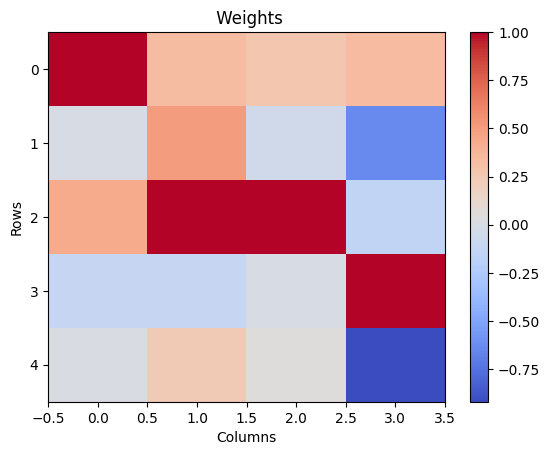

In [38]:
# plt.subplot(1, 2, 1)
plt.title(" Weights")
plt.imshow(W_normalized.detach().numpy(), cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xlabel('Columns')
plt.ylabel('Rows')

In [86]:
from torchviz import make_dot


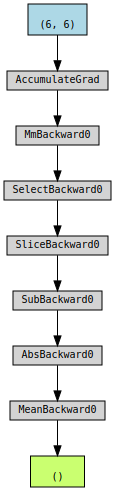

In [87]:
make_dot(loss)